# <center> Предсказание победителя в Dota 2
<center> <img src="https://meduza.io/impro/YnJZAHUW6WHz_JQm1uRPkTql_qAhbfxt3oFJLGH7CJg/fill/980/0/ce/1/aHR0cHM6Ly9tZWR1/emEuaW8vaW1hZ2Uv/YXR0YWNobWVudHMv/aW1hZ2VzLzAwNy8x/NTcvNjk1L29yaWdp/bmFsL0tMVThLbUti/ZG5pSzlibDA0Wmlw/WXcuanBn.webp" width="700" height="700">

[Почитать подбробнее](https://meduza.io/feature/2021/10/19/rossiyskaya-komanda-vyigrala-chempionat-mira-po-dota-2-i-poluchila-18-millionov-dollarov-postoyte-otkuda-takie-dengi-neuzheli-igrat-v-dotu-tak-slozhno)

#### [Оригинальная статья](https://arxiv.org/pdf/2106.01782.pdf)
    
### Начало

Посмотрим на готовые признаки и сделаем первую посылку. 

1. [Описание данных](#Описание-данных)
2. [Описание признаков](#Описание-признаков)
3. [Наша первая модель](#Наша-первая-модель)
4. [Посылка](#Посылка)

### Первые шаги на пути в датасайенс

5. [Кросс-валидация](#Кросс-валидация)
6. [Что есть в json файлах?](#Что-есть-в-json-файлах?)
7. [Feature engineering](#Feature-engineering)

### Импорты

In [48]:
import os
import json
import pandas as pd
import numpy as np
import datetime
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.model_selection import (train_test_split, 
                                     ShuffleSplit, 
                                     cross_val_score, 
                                     GridSearchCV)
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (roc_auc_score, 
                             auc,
                             roc_curve, 
                             accuracy_score, 
                             f1_score, 
                             confusion_matrix, 
                             ConfusionMatrixDisplay)

import xgboost
import lightgbm
import catboost

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

%matplotlib inline

In [49]:
SEED = 10801
sns.set_style(style="whitegrid")
plt.rcParams["figure.figsize"] = 12, 8
warnings.filterwarnings("ignore")

## <left>Описание данных

Файлы:

- `sample_submission.csv`: пример файла-посылки
- `train_raw_data.jsonl`, `test_raw_data.jsonl`: "сырые" данные 
- `train_data.csv`, `test_data.csv`: признаки, созданные авторами
- `train_targets.csv`: результаты тренировочных игр

## <left>Описание признаков
    
Набор простых признаков, описывающих игроков и команды в целом

In [50]:
PATH_TO_DATA = "./"

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             "train_data.csv"), 
                                    index_col="match_id_hash")
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            "train_targets.csv"), 
                                   index_col="match_id_hash")

In [51]:
df_train_features.shape

(31698, 245)

In [52]:
df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.00,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,8.264696,0,0,3,0,0.25,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,15.762911,3,1,0,1,0.50,0,0,3,0


Имеем ~32 тысячи наблюдений, каждое из которых характеризуется уникальным `match_id_hash` (захэшированное id матча), и 245 признаков. `game_time` показывает момент времени, в который получены эти данные. То есть по сути это не длительность самого матча, а например, его середина, таким образом, в итоге мы сможем получить модель, которая будет предсказывать вероятность победы каждой из команд в течение матча (хорошо подходит для букмекеров).

Нас интересует поле `radiant_win` (так называется одна из команд, вторая - dire). Остальные колоки здесь по сути получены из "будущего" и есть только для тренировочных данных, поэтому на них можно просто посмотреть).

In [53]:
df_train_targets.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
19c39fe2af2b547e48708ca005c6ae74,160,False,2063,1903,NaN
c96d629dc0c39f0c616d1949938a6ba6,1016,True,2147,1131,Radiant
156c88bff4e9c4668b0f53df3d870f1b,582,False,1927,1345,Dire


## <left>Наша первая модель

In [54]:
X = df_train_features.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [55]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

#### Обучим случайный лес

In [56]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
rf_model.fit(X_train, y_train)

CPU times: user 32 s, sys: 656 ms, total: 32.7 s
Wall time: 4.43 s


RandomForestClassifier(max_depth=7, n_estimators=300, n_jobs=-1,
                       random_state=10801)

#### Сделаем предсказания и оценим качество на отложенной части данных

In [68]:
y_pred = rf_model.predict_proba(X_valid)[:, 1]

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

Посмотрим на accuracy:

In [ ]:
valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

## <left>Посылка

In [60]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
                                   index_col="match_id_hash")

X_test = df_test_features.values
y_test_pred = rf_model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

In [61]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен как: {}".format(submission_filename))

Файл посылки сохранен как: submission_2023-04-09_19-11-14.csv


## <left>Кросс-валидация

Во многих случаях кросс-валидация оказывается лучше простого разбиения на test и train. Воспользуемся `ShuffleSplit` чтобы создать 5 70%/30% наборов данных.

In [ ]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

In [ ]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")

In [ ]:
cv_scores_rf

In [18]:
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.7720210676055513


## <left>Что есть в json файлах?

Описание сырых данных можно найти в `train_matches.jsonl` и `test_matches.jsonl`. Каждый файл содержит одну запись для каждого матча в [JSON](https://en.wikipedia.org/wiki/JSON) формате. Его легко превратить в питоновский объект при помощи метода `json.loads`.

In [19]:
with open(os.path.join(PATH_TO_DATA, "train_raw_data.jsonl")) as fin:
    # прочтем 419 строку
    for i in range(419):
        line = fin.readline()
    
    # переведем JSON в питоновский словарь 
    match = json.loads(line)

In [20]:
player = match["players"][9]
player["kills"], player["deaths"], player["assists"]

(0, 5, 5)

KDA - может быть неплохим признаком, этот показатель считается как:
    
<center>$KDA = \frac{K + A}{D}$

Информация о количестве использованных способностей:

In [21]:
player["ability_uses"]

{'treant_living_armor': 52, 'treant_leech_seed': 5, 'treant_overgrowth': 5}

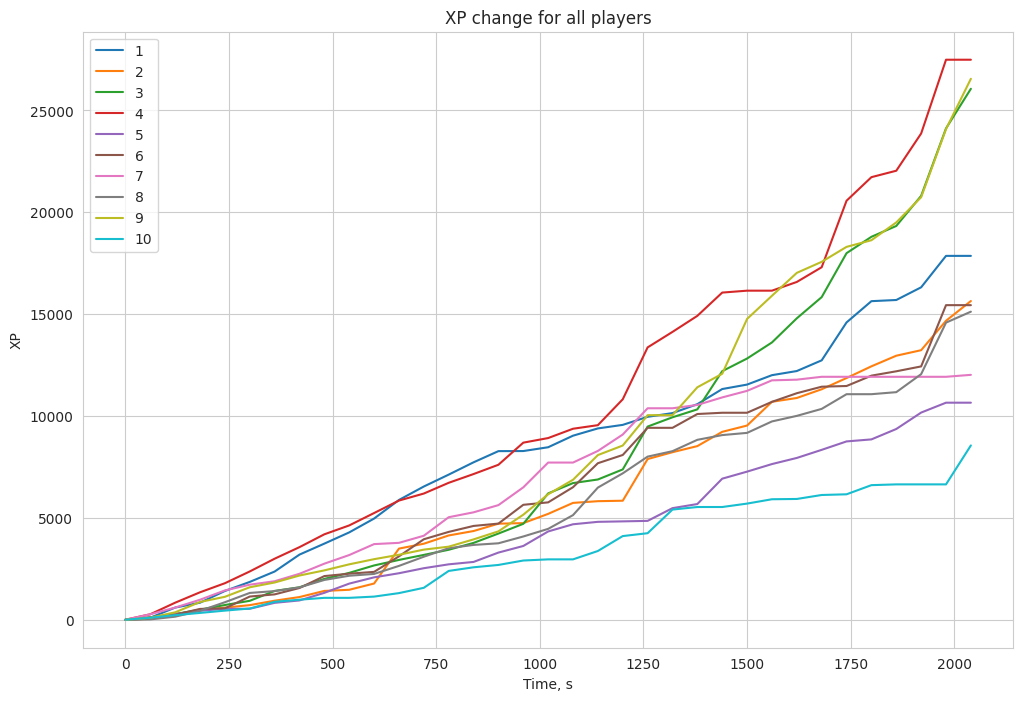

In [22]:
for i, player in enumerate(match["players"]):
    plt.plot(player["times"], player["xp_t"], label=str(i+1))

plt.legend()
plt.xlabel("Time, s")
plt.ylabel("XP")
plt.title("XP change for all players");

#### Сделаем чтение файла с сырыми данными и добавление новых признаков удобным

В этот раз для чтение `json` файлов лучше использовать библиотеку `ujson`, иначе все будет слишком долго :(

In [8]:
try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ("Подумайте об установке ujson, чтобы работать с JSON объектами быстрее")
    
try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ("Подумайте об установке tqdm, чтобы следить за прогрессом")

    
def read_matches(matches_file, total_matches=31698, n_matches_to_read=None):
    """
    Аргумент
    -------
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Возвращает записи о каждом матче
    """
    
    if n_matches_to_read is None:
        n_matches_to_read = total_matches
        
    c = 0
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            if c >= n_matches_to_read:
                break
            else:
                c += 1
                yield json.loads(line)

Подумайте об установке ujson, чтобы работать с JSON объектами быстрее


#### Чтение данных в цикле

Чтение всех данных занимает 1-2 минуты, поэтому для начала можно попробовать следующее:

1. Читать 10-50 игр
2. Написать код для работы с этими JSON объектами
3. Убедиться, что все работает
4. Запустить код на всем датасете
5. Сохранить результат в `pickle` файл, чтобы в следующий раз не переделывать все заново

## <left>Feature engineering

Напишем функцию, которая поможет нам легче добавлять новые признаки.

In [9]:
def add_new_features(df_features, matches_file):
    """
    Аргументы
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills
        
        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...

In [10]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [12]:
df_train_features_extended.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,radiant_tower_kills,dire_tower_kills,diff_tower_kills
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0,0,0.00,0,0,0,0,2.0,0.0,2.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,3,0,0.25,0,0,3,0,0.0,0.0,0.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,0,1,0.50,0,0,3,0,0.0,1.0,-1.0


In [27]:
%%time
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 119 ms, sys: 285 ms, total: 404 ms
Wall time: 51.9 s


In [28]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7720210676055513
ROC-AUC на кросс-валидации для новых признаков: 0.778796825263235


Видно, что случайный лес стал работать немного лучше при добавлении новых признаков. A еще нужно, наверное, как-то по-умному закодировать категориальные признаки.

Дальше дело за малым. Добавляйте новые признаки, пробуйте другие методы, которые мы изучили, а также что-то интересное, что мы не прошли. Удачи!

## <left>EDA

In [29]:
# Смотрим на названия всех колонок, т.к. некоторые скрыты

list(df_train_features_extended)

['game_time',
 'game_mode',
 'lobby_type',
 'objectives_len',
 'chat_len',
 'r1_hero_id',
 'r1_kills',
 'r1_deaths',
 'r1_assists',
 'r1_denies',
 'r1_gold',
 'r1_lh',
 'r1_xp',
 'r1_health',
 'r1_max_health',
 'r1_max_mana',
 'r1_level',
 'r1_x',
 'r1_y',
 'r1_stuns',
 'r1_creeps_stacked',
 'r1_camps_stacked',
 'r1_rune_pickups',
 'r1_firstblood_claimed',
 'r1_teamfight_participation',
 'r1_towers_killed',
 'r1_roshans_killed',
 'r1_obs_placed',
 'r1_sen_placed',
 'r2_hero_id',
 'r2_kills',
 'r2_deaths',
 'r2_assists',
 'r2_denies',
 'r2_gold',
 'r2_lh',
 'r2_xp',
 'r2_health',
 'r2_max_health',
 'r2_max_mana',
 'r2_level',
 'r2_x',
 'r2_y',
 'r2_stuns',
 'r2_creeps_stacked',
 'r2_camps_stacked',
 'r2_rune_pickups',
 'r2_firstblood_claimed',
 'r2_teamfight_participation',
 'r2_towers_killed',
 'r2_roshans_killed',
 'r2_obs_placed',
 'r2_sen_placed',
 'r3_hero_id',
 'r3_kills',
 'r3_deaths',
 'r3_assists',
 'r3_denies',
 'r3_gold',
 'r3_lh',
 'r3_xp',
 'r3_health',
 'r3_max_health',
 '

In [30]:
# Все признаки числовых типов int64 и float64

df_train_features_extended.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 31698 entries, b9c57c450ce74a2af79c9ce96fac144d to e2ca68ac1a6847f4a37f6c9c8ee8695b
Data columns (total 248 columns):
 #    Column                      Dtype  
---   ------                      -----  
 0    game_time                   int64  
 1    game_mode                   int64  
 2    lobby_type                  int64  
 3    objectives_len              int64  
 4    chat_len                    int64  
 5    r1_hero_id                  int64  
 6    r1_kills                    int64  
 7    r1_deaths                   int64  
 8    r1_assists                  int64  
 9    r1_denies                   int64  
 10   r1_gold                     int64  
 11   r1_lh                       int64  
 12   r1_xp                       int64  
 13   r1_health                   int64  
 14   r1_max_health               int64  
 15   r1_max_mana                 float64
 16   r1_level                    int64  
 17   r1_x                        int64

In [31]:
# получаем основные описательные статистики

df_train_features_extended.describe().round(2)

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,radiant_tower_kills,dire_tower_kills,diff_tower_kills
count,31698.00,31698.00,31698.00,31698.00,31698.00,31698.00,31698.00,31698.00,31698.00,31698.00,...,31698.00,31698.00,31698.00,31698.00,31698.00,31698.00,31698.00,31698.00,31698.00,31698.00
mean,1146.52,19.58,4.77,6.54,7.36,51.08,3.15,3.27,4.66,6.26,...,4.70,0.09,0.42,0.30,0.02,1.26,0.78,2.19,1.98,0.21
std,766.94,6.31,3.26,6.49,13.30,34.57,3.73,3.28,5.21,8.14,...,4.66,0.28,0.27,0.73,0.17,2.58,2.44,2.57,2.50,2.67
min,0.00,2.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-11.00
25%,521.00,22.00,0.00,1.00,0.00,20.00,0.00,1.00,1.00,1.00,...,1.00,0.00,0.24,0.00,0.00,0.00,0.00,0.00,0.00,-1.00
50%,1044.00,22.00,7.00,4.00,3.00,44.00,2.00,2.00,3.00,3.00,...,3.00,0.00,0.44,0.00,0.00,0.00,0.00,1.00,1.00,0.00
75%,1659.00,22.00,7.00,10.00,9.00,81.00,5.00,5.00,7.00,9.00,...,7.00,0.00,0.60,0.00,0.00,1.00,0.00,4.00,3.00,1.00
max,4933.00,23.00,7.00,43.00,291.00,120.00,32.00,27.00,40.00,83.00,...,57.00,1.00,2.00,9.00,5.00,26.00,47.00,11.00,11.00,11.00


In [32]:
# в наших данных нет нулевых показателей

df_train_features_extended.isnull().sum().sum()

0

In [138]:
# и нет NA

df_train_features_extended.isna().sum().sum()

0

In [34]:
# баланс классов соблюдён

df_train_targets[["radiant_win"]].value_counts()

radiant_win
True           16670
False          15028
dtype: int64

In [35]:
len(np.unique(df_train_features_extended.game_mode))

8

In [36]:
len(np.unique(df_train_features_extended.lobby_type))

2

In [37]:
len(np.unique(df_train_features_extended.r1_firstblood_claimed))

2

In [38]:
len(np.unique(df_train_features_extended.r2_firstblood_claimed))

2

In [39]:
len(np.unique(df_train_features_extended.r3_firstblood_claimed))

2

In [40]:
len(np.unique(df_train_features_extended.r4_firstblood_claimed))

2

In [41]:
len(np.unique(df_train_features_extended.r5_firstblood_claimed))

2

In [42]:
len(np.unique(df_train_features_extended.d1_firstblood_claimed))

2

In [43]:
len(np.unique(df_train_features_extended.d2_firstblood_claimed))

2

In [44]:
len(np.unique(df_train_features_extended.d3_firstblood_claimed))

2

In [45]:
len(np.unique(df_train_features_extended.d4_firstblood_claimed))

2

In [46]:
len(np.unique(df_train_features_extended.d5_firstblood_claimed))

2

## <left>Feature engineering

In [19]:
cat_cols = ["game_mode", 
            "lobby_type", 
            "r1_firstblood_claimed", 
            "r2_firstblood_claimed", 
            "r3_firstblood_claimed", 
            "r4_firstblood_claimed", 
            "r5_firstblood_claimed", 
            "d1_firstblood_claimed", 
            "d2_firstblood_claimed", 
            "d3_firstblood_claimed", 
            "d4_firstblood_claimed", 
            "d5_firstblood_claimed"]

num_cols = list(df_train_features_extended.drop(cat_cols, axis=1))
all_features = cat_cols + num_cols

In [20]:
X = df_train_features_extended[all_features]
X

,game_mode,lobby_type,r1_firstblood_claimed,r2_firstblood_claimed,r3_firstblood_claimed,r4_firstblood_claimed,r5_firstblood_claimed,d1_firstblood_claimed,d2_firstblood_claimed,d3_firstblood_claimed,...,d5_camps_stacked,d5_rune_pickups,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,radiant_tower_kills,dire_tower_kills,diff_tower_kills
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,4,0,0,0,0,0,0,0,1,0,...,0,0,0.000000,0,0,0,0,2.0,0.0,2.0
6db558535151ea18ca70a6892197db41,23,0,0,0,0,0,0,0,0,0,...,0,0,0.000000,0,0,0,0,0.0,0.0,0.0
19c39fe2af2b547e48708ca005c6ae74,22,7,0,0,0,0,0,0,0,0,...,0,0,0.000000,0,0,0,0,0.0,0.0,0.0
c96d629dc0c39f0c616d1949938a6ba6,22,0,0,0,0,0,1,0,0,0,...,0,3,0.250000,0,0,3,0,0.0,0.0,0.0
156c88bff4e9c4668b0f53df3d870f1b,22,7,0,0,0,0,0,0,0,0,...,1,0,0.500000,0,0,3,0,0.0,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b794aa55646841a03c7783226e6f6bc8,22,0,0,0,0,0,0,0,0,0,...,1,17,0.390244,2,2,0,0,4.0,8.0,-4.0
308faee28efee2e66b39f9f2ba6ea9cf,22,0,0,0,0,0,0,1,0,0,...,2,10,0.263158,0,0,15,6,6.0,4.0,2.0
6066cc7417b43c749d551e123d00f0c8,4,0,0,0,0,0,0,0,0,0,...,0,15,0.555556,0,0,0,0,2.0,1.0,1.0


In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.1, 
                                                      random_state=SEED)

In [22]:
preprocessor = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(), num_cols),
    ("ohe", OneHotEncoder(), cat_cols)
])

In [23]:
preprocessor.transformers

[('scaler',
  StandardScaler(),
  ['game_time',
   'objectives_len',
   'chat_len',
   'r1_hero_id',
   'r1_kills',
   'r1_deaths',
   'r1_assists',
   'r1_denies',
   'r1_gold',
   'r1_lh',
   'r1_xp',
   'r1_health',
   'r1_max_health',
   'r1_max_mana',
   'r1_level',
   'r1_x',
   'r1_y',
   'r1_stuns',
   'r1_creeps_stacked',
   'r1_camps_stacked',
   'r1_rune_pickups',
   'r1_teamfight_participation',
   'r1_towers_killed',
   'r1_roshans_killed',
   'r1_obs_placed',
   'r1_sen_placed',
   'r2_hero_id',
   'r2_kills',
   'r2_deaths',
   'r2_assists',
   'r2_denies',
   'r2_gold',
   'r2_lh',
   'r2_xp',
   'r2_health',
   'r2_max_health',
   'r2_max_mana',
   'r2_level',
   'r2_x',
   'r2_y',
   'r2_stuns',
   'r2_creeps_stacked',
   'r2_camps_stacked',
   'r2_rune_pickups',
   'r2_teamfight_participation',
   'r2_towers_killed',
   'r2_roshans_killed',
   'r2_obs_placed',
   'r2_sen_placed',
   'r3_hero_id',
   'r3_kills',
   'r3_deaths',
   'r3_assists',
   'r3_denies',
   'r3_

## <left>Попытка подбора модели перебором

In [178]:
%%time
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)

base_models = [("DT", dt), 
          ("RF", rf), 
          ("ETC", etc), 
          ("KNN", knn), 
          ("CAT", cat), 
          ("LGBM", lgbm), 
          ("LGBM_RF", lgbm_rf), 
          ("XGB", xgb), 
          ("XGB_RF", xgb_rf), 
          ("LR", lr)]

for name, model in models:
    print(f"Fitting {name}")
    model.fit(X_train, y_train)

voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_hard.fit(X_train, y_train)

voting_soft = VotingClassifier(estimators=base_models, voting='soft')
voting_soft.fit(X_train, y_train)

Fitting RF
Fitting ETC
Fitting CAT
Fitting LGBM
Fitting LGBM_RF
Fitting XGB
Fitting XGB_RF
Fitting LR
CPU times: user 59min 24s, sys: 42 s, total: 1h 6s
Wall time: 12min 1s


VotingClassifier(estimators=[('DT',
                              DecisionTreeClassifier(max_depth=10,
                                                     min_samples_leaf=10,
                                                     random_state=10801)),
                             ('RF',
                              RandomForestClassifier(max_depth=7,
                                                     n_estimators=300,
                                                     n_jobs=-1,
                                                     random_state=10801)),
                             ('ETC', ExtraTreesClassifier(random_state=10801)),
                             ('KNN', KNeighborsClassifier(weights='distance')),
                             ('CAT',
                              <catboost.core.CatBoostClassifier object at 0x7...
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              objective='binary:logistic',
                                              predictor=None,
                                              random_state=10801,
                                              reg_alpha=None, ...)),
                             ('LR',
                              LogisticRegression(max_iter=10000,
                                                 solver='liblinear'))],
                 voting='soft')

In [179]:
%%time
for model in [dt, rf, etc, knn, cat, lgbm, lgbm_rf, xgb, xgb_rf, lr, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.6754237837408154
RandomForestClassifier: 0.7380795386528958
ExtraTreesClassifier: 0.7280274544970702
KNeighborsClassifier: 0.6984526574543659
CatBoostClassifier: 0.7385152773169945
LGBMClassifier: 0.7317766599868553
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Cu

In [180]:
models = [("RF", rf), 
          ("ETC", etc), 
          ("CAT", cat), 
          ("LGBM", lgbm), 
          ("LGBM_RF", lgbm_rf), 
          ("XGB", xgb), 
          ("XGB_RF", xgb_rf), 
          ("LR", lr)]

In [188]:
%%time # Работало больше суток, в итоге было остановлено
for i in range(2, 9):
    for cur_estimators in combinations(models, i):
        voting_hard = VotingClassifier(estimators=list(cur_estimators), 
                                       voting='hard')
        voting_hard.fit(X_train, y_train)

        voting_soft = VotingClassifier(estimators=list(cur_estimators), 
                                       voting='soft')
        voting_soft.fit(X_train, y_train)

        cross_val_scores = []

        for model in [voting_hard, voting_soft]: 
            cv_score = cross_val_score(model, X_train, y_train, cv=cv, scoring="f1")
            cross_val_scores.append(cv_score.mean())
        print(*cross_val_scores)
        print(*[name for name, model in cur_estimators])

        if any([x > 0.75 for x in cross_val_scores]):
            print('***************************************************************************************************')
            print(*cross_val_scores)
            print(*[name for name, model in cur_estimators])
            print('***************************************************************************************************')

0.7181161332340047 0.7392904096187287
RF ETC
0.7268608658354301 0.7417625767426919
RF CAT
0.7226786624036253 0.7384601026377509
RF LGBM
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ign

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagg

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
0.7379723233446176 0.7376180178048695
RF ETC LGBM_RF
0.7382683460382082 0.7358097882973126
RF ETC XG

0.7319612985859821 0.7332568427426316
RF LGBM_RF XGB_RF
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagg

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
0.7317144277275044 0.7376295820792182
CAT LGBM_RF XGB_RF
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is se

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagg

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
0.7301053723811239 0.736555918373888
RF ETC LGBM_RF XGB_RF
[LightGBM] [Warning] bagging_fraction is 

0.7317292785518242 0.7390771136214068
RF CAT LGBM_RF XGB_RF
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagg

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
0.7375618860928208 0.7471332096634328
ETC CAT LGBM_RF LR


KeyboardInterrupt: 

## <left>Feature selection

In [24]:
# применим sklearn.feature_selection
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=0)
sel.fit(X_train)  # найти все переменные с нулевой дисперсией

VarianceThreshold(threshold=0)

In [25]:
# get_support - это булевый вектор, который указывает, какие признаки сохраняются.
# если мы просуммируем get_support, то получим количество функций, которые не являются постоянными
sum(sel.get_support())

# видим, что все исходные фичи остаются

248

In [26]:
sel = VarianceThreshold(threshold=0.01)  # 0.1 indicates 99% of observations approximately

sel.fit(X_train)

VarianceThreshold(threshold=0.01)

In [27]:
# Посмотрим, сколько осталось признаков
sum(sel.get_support())
len(X_train.columns[sel.get_support()])

# все :)

248

In [28]:
from sklearn.feature_selection import SelectKBest, chi2

In [29]:
X_new = SelectKBest(chi2, k=100).fit_transform(X_train, y_train)
X_new.shape
# Input X must be non-negative, а я не уверена, можно ли взять и скормить только неотрицательную часть данных. 
# Аналогично для SelectPercentile

ValueError: Input X must be non-negative.

## <left>RFECV

In [35]:
def add_new_features(df_features):
    """
    Аргументы
    -------
    df_features: таблица с данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    

    # Посчитаем KDA для команд
    df_features["radiant_kills"] = df_features[["r1_kills", "r2_kills", "r3_kills", "r4_kills", "r5_kills"]].sum(axis=1)
    df_features["dire_kills"] = df_features[["d1_kills", "d2_kills", "d3_kills", "d4_kills", "d5_kills"]].sum(axis=1)

    df_features["radiant_deaths"] = df_features[["r1_deaths", "r2_deaths", "r3_deaths", "r4_deaths", "r5_deaths"]].sum(axis=1)
    df_features["dire_deaths"] = df_features[["d1_deaths", "d2_deaths", "d3_deaths", "d4_deaths", "d5_deaths"]].sum(axis=1)

    df_features["radiant_assists"] = df_features[["r1_assists", "r2_assists", "r3_assists", "r4_assists", "r5_assists"]].sum(axis=1)
    df_features["dire_assists"] = df_features[["d1_assists", "d2_assists", "d3_assists", "d4_assists", "d5_assists"]].sum(axis=1)


    df_features["radiant_kda"] = df_features.apply(lambda row: 
                                                             (row.radiant_kills + row.radiant_assists) / row.radiant_deaths 
                                                   if row.radiant_deaths != 0 else row.radiant_kills + row.radiant_assists, 
                                                             axis = 1)
    df_features["dire_kda"] = df_features.apply(lambda row: 
                                                             (row.dire_kills + row.dire_assists) / row.dire_deaths 
                                                if row.dire_deaths != 0 else row.dire_kills + row.dire_assists, 
                                                             axis = 1)
    
    # Посчитаем золото для команд
    df_features["radiant_gold"] = df_features[["r1_gold", "r2_gold", "r3_gold", "r4_gold", "r5_gold"]].sum(axis=1)
    df_features["dire_gold"] = df_features[["d1_gold", "d2_gold", "d3_gold", "d4_gold", "d5_gold"]].sum(axis=1)
    
    # Посчитаем опыт для команд
    df_features["radiant_xp"] = df_features[["r1_xp", "r2_xp", "r3_xp", "r4_xp", "r5_xp"]].sum(axis=1)
    df_features["dire_xp"] = df_features[["d1_xp", "d2_xp", "d3_xp", "d4_xp", "d5_xp"]].sum(axis=1)
    
    # Посчитаем повреждение здоровья для каждого игрока в процентах
    df_features["r1_hurt"] = df_features.apply(lambda row: 100 - row.r1_health * 100 / row.r1_max_health, axis = 1)
    df_features["r2_hurt"] = df_features.apply(lambda row: 100 - row.r2_health * 100 / row.r2_max_health, axis = 1)
    df_features["r3_hurt"] = df_features.apply(lambda row: 100 - row.r3_health * 100 / row.r3_max_health, axis = 1)
    df_features["r4_hurt"] = df_features.apply(lambda row: 100 - row.r4_health * 100 / row.r4_max_health, axis = 1)
    df_features["r5_hurt"] = df_features.apply(lambda row: 100 - row.r5_health * 100 / row.r5_max_health, axis = 1)
    
    df_features["d1_hurt"] = df_features.apply(lambda row: 100 - row.d1_health * 100 / row.d1_max_health, axis = 1)
    df_features["d2_hurt"] = df_features.apply(lambda row: 100 - row.d2_health * 100 / row.d2_max_health, axis = 1)
    df_features["d3_hurt"] = df_features.apply(lambda row: 100 - row.d3_health * 100 / row.d3_max_health, axis = 1)
    df_features["d4_hurt"] = df_features.apply(lambda row: 100 - row.d4_health * 100 / row.d4_max_health, axis = 1)
    df_features["d5_hurt"] = df_features.apply(lambda row: 100 - row.d5_health * 100 / row.d5_max_health, axis = 1)
    
    df_features["radiant_hurt"] = df_features[["r1_hurt", "r2_hurt", "r3_hurt", "r4_hurt", "r5_hurt"]].sum(axis=1)
    df_features["dire_hurt"] = df_features[["d1_hurt", "d2_hurt", "d3_hurt", "d4_hurt", "d5_hurt"]].sum(axis=1)
    df_features["diff_hurt"] = df_features.apply(lambda row: row.radiant_hurt - row.dire_hurt, axis = 1)
    
    # Посчитаем затраты маны для каждого игрока в процентах
    df_features["r1_mana_spent"] = df_features.apply(lambda row: 100 - row.r1_health * 100 / row.r1_max_health, axis = 1)
    df_features["r2_mana_spent"] = df_features.apply(lambda row: 100 - row.r2_health * 100 / row.r2_max_health, axis = 1)
    df_features["r3_mana_spent"] = df_features.apply(lambda row: 100 - row.r3_health * 100 / row.r3_max_health, axis = 1)
    df_features["r4_mana_spent"] = df_features.apply(lambda row: 100 - row.r4_health * 100 / row.r4_max_health, axis = 1)
    df_features["r5_mana_spent"] = df_features.apply(lambda row: 100 - row.r5_health * 100 / row.r5_max_health, axis = 1)
    
    df_features["d1_mana_spent"] = df_features.apply(lambda row: 100 - row.d1_health * 100 / row.d1_max_health, axis = 1)
    df_features["d2_mana_spent"] = df_features.apply(lambda row: 100 - row.d2_health * 100 / row.d2_max_health, axis = 1)
    df_features["d3_mana_spent"] = df_features.apply(lambda row: 100 - row.d3_health * 100 / row.d3_max_health, axis = 1)
    df_features["d4_mana_spent"] = df_features.apply(lambda row: 100 - row.d4_health * 100 / row.d4_max_health, axis = 1)
    df_features["d5_mana_spent"] = df_features.apply(lambda row: 100 - row.d5_health * 100 / row.d5_max_health, axis = 1)
    
    df_features["radiant_mana_spent"] = df_features[["r1_hurt", "r2_hurt", "r3_hurt", "r4_hurt", "r5_hurt"]].sum(axis=1)
    df_features["dire_mana_spent"] = df_features[["d1_hurt", "d2_hurt", "d3_hurt", "d4_hurt", "d5_hurt"]].sum(axis=1)
    df_features["diff_mana_spent"] = df_features.apply(lambda row: row.radiant_hurt - row.dire_hurt, axis = 1)


In [38]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features_extended.copy()

# Добавим новые
add_new_features(df_train_features_extended)

In [43]:
corr_df = df_train_features_extended.corr()

In [44]:
for i in list(corr_df):
    for j in list(corr_df.columns):
        if 1 > corr_df[i][j] >= 0.95:
            print(i, j, corr_df[i][j])

In [41]:
df_train_features_extended = df_train_features_extended.drop(["radiant_kills", 
                                                              "radiant_deaths", 
                                                              "radiant_assists",
                                                              "radiant_xp",
                                                              "dire_assists", 
                                                              "radiant_gold",
                                                              "dire_gold",
                                                              "r1_hurt", 
                                                              "r2_hurt", 
                                                              "r3_hurt", 
                                                              "r4_hurt", 
                                                              "r5_hurt",
                                                              "d1_hurt", 
                                                              "d2_hurt", 
                                                              "d3_hurt", 
                                                              "d4_hurt", 
                                                              "d5_hurt",
                                                              "r1_level", 
                                                              "r2_level", 
                                                              "r3_level", 
                                                              "r4_level", 
                                                              "r5_level",
                                                              "d1_level", 
                                                              "d2_level", 
                                                              "d3_level", 
                                                              "d4_level", 
                                                              "d5_level", 
                                                              "r1_xp", 
                                                              "r2_xp", 
                                                              "r3_xp", 
                                                              "r4_xp", 
                                                              "r5_xp",
                                                              "d1_xp", 
                                                              "d2_xp", 
                                                              "d3_xp", 
                                                              "d4_xp", 
                                                              "d5_xp"
                                                              ], axis=1)

In [45]:
def data_scaling(DataFrame):
    sc = StandardScaler()
    DataFrame.iloc[:,1:] = sc.fit_transform(DataFrame.iloc[:,1:])
    return(DataFrame)
X_train_scaled = data_scaling(X_train)

In [46]:
print(X_train_scaled.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(28528, 248)
(28528,)
(3170, 248)
(3170,)


In [ ]:
# Подобралось 179 признаков; по техническим причинам (кривых рук) ячейка сбросилась, заново запускать уже не было времени 
# и возможности: работало ночь и утро

%%time 

from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

cat = catboost.CatBoostClassifier(depth=6, 
                                  learning_rate=0.05,
                                  random_seed=SEED)

rfecv = RFECV(
    estimator=cat,
    step=1,
    cv=5,
    scoring="roc_auc",
    min_features_to_select=150,
    n_jobs=-1,
)
rfecv.fit(X_train, y_train)

print(f"Optimal number of features: {rfecv.n_features_}")

In [ ]:
# Не удалось показать сами признаки и график ниже по той же причине, к сожалению

for col in df_train_features_extended.columns[rfecv.support_]: 
    print(col)
print(len(df_train_features_extended.columns[rfecv.support_]))

In [ ]:
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test roc_auc")
plt.plot(
    range(150, n_scores + 150),
    rfecv.cv_results_["mean_test_score"]
)
plt.title("Recursive feature elimination with correlated features")
plt.show()

In [ ]:
best_features = df_train_features_extended.columns[rfecv.support_]
X_best = df_train_features_extended.loc[:, df_train_features_extended.columns.isin(best_features)]
X_best